# M= 2^20

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv();

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

from icl.analysis.utils import get_unique_run
from devinterp.mechinterp.hooks import hook

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

PRIMARY, SECONDARY, TERTIARY = sns.color_palette()[:3]
BBLUE, BORANGE, BGREEN, BRED = sns.color_palette('bright')[:4]


sns.set_style('whitegrid')

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [149]:
run = get_unique_run(
    "../sweeps/small-sweep-2.yaml", 
    task_config={"num_tasks": 2**20, "num_layers": 2},
    optimizer_config={"lr": 0.01}
)

/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(


In [4]:
steps = run.checkpointer.file_ids

In [134]:
from copy import deepcopy 
# Let's generate these same plots and also look at their evolution. 
models = []
optimizer_state_dicts = []

for checkpoint in run.checkpointer:
    m = deepcopy(run.model)
    m.load_state_dict(checkpoint["model"])
    models.append(m)
    optimizer_state_dicts.append(checkpoint["optimizer"])


In [150]:
model = deepcopy(run.model)

In [87]:
# Let's look at how the curvature of the llc changes over time. 

import wandb

api = wandb.Api()
llc_run = api.run("devinterp/icl/3e5e1h1k")  # TODO: Replace with newer run
history_df = llc_run.history()
print(history_df)
steps = history_df["_step"]
# llcs = history_df["llc/mean"]
# llcs_std = history_df["llc/std"]
llc_chain_columns = [f'llc-chain/{i}' for i in range(25)]
history_df[llc_chain_columns] = history_df[llc_chain_columns].replace("NaN", np.nan)

# Calculate the average of non-NaN values in llc-chain columns
# and the fraction of NaN values
llc_chain_values = history_df[llc_chain_columns]
mean_llc_chain = llc_chain_values.mean(axis=1, skipna=True)
frac_nan = llc_chain_values.isna().mean(axis=1)

history_df["llc/mean-fixed"] = mean_llc_chain
history_df["llc/frac-nan"] = frac_nan

llcs = history_df["llc/mean-fixed"]
llcs_std = history_df["llc/std"]


    llc-chain/6   llc/std  llc-chain/9       _runtime  llc-chain/21  \
0      1.194732  3.978169    -3.628153   38087.031903      3.781510   
1     -2.150306   4.33915     0.034306   38851.315485     -1.607957   
2     -6.074535  4.833769     3.234652   39628.065992      2.778879   
3     -3.736918  4.356052    -0.816870   40394.221013      3.327850   
4     -3.297347   4.74464    -1.630429   41177.652552     -1.406416   
..          ...       ...          ...            ...           ...   
91   172.350128  5.701548   158.896820  107514.002800    166.442200   
92   162.770706  5.595061   156.684189  108251.913242    162.943680   
93   152.194870  7.219752   165.755188  109028.805507    166.779587   
94   168.952347  6.587491   157.912354  109766.426697    164.773575   
95   170.018829  7.445742   162.231201  110509.565546    171.803116   

    llc-chain/16  llc-chain/1  llc-chain/0  llc-chain/11  llc-chain/14  ...  \
0      -0.059877     1.523142    10.585353      8.853766     -3.0070

In [7]:
weight_norms = [(sum(torch.norm(p) ** 2 for p in model.parameters()) ** 0.5).item() for model in models]

def d_dt(steps, values):
    slope = np.zeros(len(steps))

    # Compute Slope and Curvature
    for i in range(1, len(steps) - 1):
        dx1 = steps[i+1] - steps[i]
        dx0 = steps[i] - steps[i-1]
        
        dy1 = values[i+1] - values[i]
        dy0 = values[i] - values[i-1]
        
        slope[i] = (dy1 / dx1 + dy0 / dx0) / 2

    return slope

def d_dlogt(steps, values):
    slope = np.zeros(len(steps))

    # Compute Slope and Curvature
    for i in range(1, len(steps) - 1):
        logti = np.log(steps[i] + 1)
        logtip1 = np.log(steps[i+1] + 1)
        logtim1 = np.log(steps[i-1] + 1)

        dlogt1 = logtip1 - logti
        dlogt0 = logti - logtim1
        
        dy1 = values[i+1] - values[i]
        dy0 = values[i] - values[i-1]
        
        slope[i] = (dy1 / dlogt1 + dy0 / dlogt0) / 2

    return slope

d_llc_dt = d_dt(steps, llcs)
d_llc_dlogt = d_dlogt(steps, llcs)

d_weight_norm_dt = d_dt(run.checkpointer.file_ids, weight_norms)
d_weight_norm_dlogt = d_dlogt(run.checkpointer.file_ids, weight_norms)

In [8]:
from icl.evals import ICLEvaluator

evaluator = ICLEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=10_000,
    seed=run.config.task_config.true_seed,
)

evals_over_time = [evaluator(model) for model in models]
evals_over_time_df = pd.DataFrame(evals_over_time)
evals_over_time_df

,pretrain/mse,pretrain/delta_dmmse,pretrain/delta_ridge,pretrain/token/0,pretrain/token/1,pretrain/token/2,pretrain/token/3,pretrain/token/4,pretrain/token/5,pretrain/token/6,...,true/delta_dmmse,true/delta_ridge,true/token/0,true/token/1,true/token/2,true/token/3,true/token/4,true/token/5,true/token/6,true/token/7
0,4.658624,"tensor(3.0025, device='mps:0')","tensor(3.0011, device='mps:0')",4.776212,4.575686,4.715003,4.547464,4.613040,4.701172,4.626709,...,"tensor(3.0443, device='mps:0')","tensor(3.0475, device='mps:0')",4.836447,4.773668,4.676454,4.563488,4.653704,4.773315,4.729661,4.697273
1,4.658603,"tensor(3.0025, device='mps:0')","tensor(3.0011, device='mps:0')",4.776184,4.575664,4.714978,4.547450,4.613023,4.701149,4.626690,...,"tensor(3.0443, device='mps:0')","tensor(3.0475, device='mps:0')",4.836419,4.773646,4.676428,4.563473,4.653688,4.773290,4.729641,4.697253
2,4.658571,"tensor(3.0024, device='mps:0')","tensor(3.0011, device='mps:0')",4.776143,4.575632,4.714942,4.547429,4.612998,4.701113,4.626662,...,"tensor(3.0443, device='mps:0')","tensor(3.0475, device='mps:0')",4.836376,4.773612,4.676390,4.563452,4.653666,4.773253,4.729614,4.697221
3,4.658529,"tensor(3.0024, device='mps:0')","tensor(3.0010, device='mps:0')",4.776088,4.575590,4.714892,4.547400,4.612964,4.701066,4.626625,...,"tensor(3.0442, device='mps:0')","tensor(3.0474, device='mps:0')",4.836319,4.773569,4.676338,4.563423,4.653637,4.773205,4.729576,4.697180
4,4.658477,"tensor(3.0023, device='mps:0')","tensor(3.0010, device='mps:0')",4.776020,4.575537,4.714831,4.547364,4.612922,4.701008,4.626577,...,"tensor(3.0442, device='mps:0')","tensor(3.0474, device='mps:0')",4.836249,4.773513,4.676274,4.563386,4.653600,4.773143,4.729529,4.697128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.788642,"tensor(0.1328, device='mps:0')","tensor(0.1319, device='mps:0')",4.121357,3.088294,2.315449,1.632422,1.127852,0.832039,0.670486,...,"tensor(0.1305, device='mps:0')","tensor(0.1307, device='mps:0')",4.163236,3.246097,2.262283,1.594268,1.124972,0.822146,0.669757,0.551348
92,1.785783,"tensor(0.1302, device='mps:0')","tensor(0.1293, device='mps:0')",4.122046,3.085954,2.318604,1.633553,1.115488,0.828213,0.667536,...,"tensor(0.1281, device='mps:0')","tensor(0.1282, device='mps:0')",4.164718,3.250714,2.269203,1.588718,1.119651,0.818764,0.662516,0.547854
93,1.782165,"tensor(0.1256, device='mps:0')","tensor(0.1248, device='mps:0')",4.121902,3.084441,2.319178,1.622279,1.113624,0.823878,0.659083,...,"tensor(0.1221, device='mps:0')","tensor(0.1223, device='mps:0')",4.164491,3.243809,2.267420,1.580230,1.114218,0.808007,0.657443,0.536615
94,1.777578,"tensor(0.1220, device='mps:0')","tensor(0.1211, device='mps:0')",4.121686,3.083040,2.314546,1.622109,1.110453,0.812696,0.650287,...,"tensor(0.1196, device='mps:0')","tensor(0.1198, device='mps:0')",4.164260,3.244334,2.263615,1.582577,1.107713,0.803125,0.652842,0.536422


# Progress measures

In [74]:
MILESTONES = [
    (0, 30, 'Burn-in'),
    (30, 800, 'A1'),
    (800, 10_000, 'A2'),
    (10_000, 28000, 'B1'),
    (28000, 100_000, 'B2'),
    (100_000, 280_000, 'B3'),
    (280_000, 500_000, "Convergence"),
    # (320000, 500000, "?")
]

MILESTONE_COLORS = sns.color_palette("coolwarm_r", len(MILESTONES))
print(MILESTONE_COLORS)

def add_milestones(axes, milestones=MILESTONES, milestone_colors=MILESTONE_COLORS, max_step=np.inf):
    for ax in axes.flatten():
        for color, (start, end, label) in zip(milestone_colors, milestones):

            if start > max_step:
                continue

            ax.axvspan(start, min(end, max_step), alpha=0.5, label=label, color=color)

    # Add milestone legend
    patch_list = []

    for color, (start, end, label) in zip(milestone_colors, milestones):
        data_key = mpatches.Patch(color=color, alpha=0.2, label=label)
        patch_list.append(data_key)

    return patch_list

[(0.8696552305058823, 0.37927381945098043, 0.30094110221960785), (0.9582793979254902, 0.604335096882353, 0.48329710138823534), (0.9581760317411765, 0.7712340904, 0.6803010368117647), (0.863391831290196, 0.8650837958196078, 0.8676338842627451), (0.7189852929803922, 0.811992893745098, 0.9776561613921568), (0.5488761722823529, 0.6851035851764705, 0.9943791404235295), (0.3785982492705882, 0.5038562171921569, 0.9136916108470589)]


## Unsupervised Observables

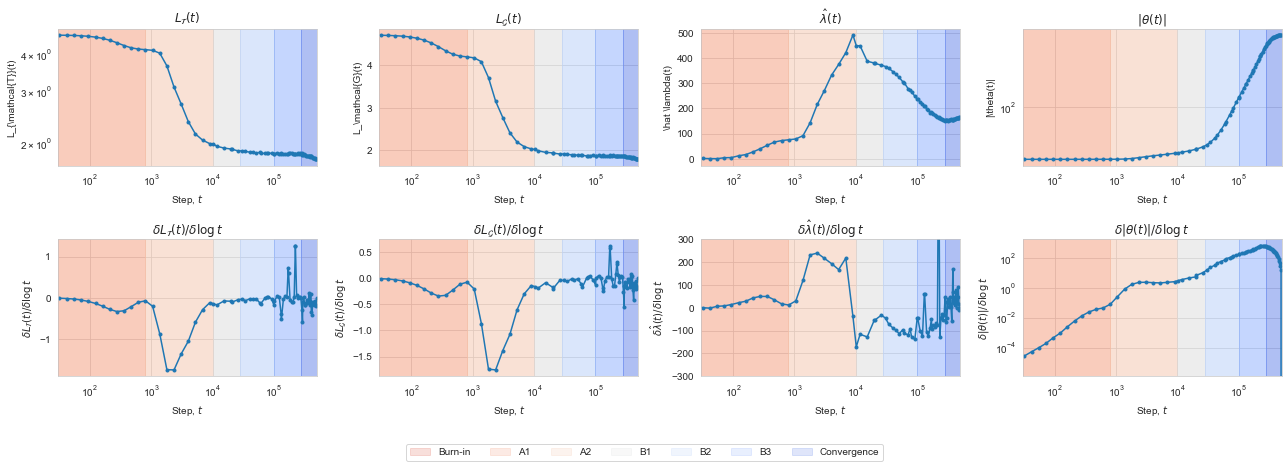

In [186]:
import seaborn as sns

def wrap_latex(s):
    return "$" + s + "$"

def add_d_dlogt(s):
    return wrap_latex(r"\delta " + s + r"/\delta\log t")

metrics_to_plot = [
    (r"L_{\mathcal{T}}(t)", evals_over_time_df["pretrain/mse"], {"logy": True}),
    (r"L_\mathcal{G}(t)", evals_over_time_df["true/mse"], {"logy": False}),
    (r"\hat \lambda(t)", llcs, {}),
    (r"|\theta(t)|", weight_norms, {}),
] 

metric_slopes = [
    # d_dt(run.checkpointer.file_ids, v) for _, v, __ in metrics_to_plot
    d_dlogt(run.checkpointer.file_ids, v) for _, v, __ in metrics_to_plot
]

fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(18, 6))

for i, (metric_name, metric_values, kwargs) in enumerate(metrics_to_plot):
    axes[0, i].plot(run.checkpointer.file_ids, metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(wrap_latex(metric_name))
    axes[0, i].set_xlabel('Step, $t$')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    axes[1, i].plot(run.checkpointer.file_ids, metric_slopes[i], label=metric_name + " Slope", marker='.')
    axes[1, i].set_title(add_d_dlogt(metric_name))
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(add_d_dlogt(metric_name))

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(30, 500_000)


axes[0, 3].set_yscale('log')
axes[1, 3].set_yscale('log')
axes[1,2].set_ylim(-300, 300)

patch_list = add_milestones(axes)

milestone_labels = [label for _, _, label in MILESTONES]
fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(MILESTONES))

fig.set_facecolor("white")
fig.tight_layout()

## Embedding vectors

In [93]:
steps = run.checkpointer.file_ids
embedding_matrices = []  # Shape: (64, 5): 64 vectors x (1 y dim + 4 x dims)

for model in models:
    embedding_matrices.append(model.state_dict()['token_sequence_transformer.token_embedding.weight'])


embedding_vec_x_norms = [vec.norm(dim=1) for vec in embedding_matrices]  # (64,)

Text(0.5, 0, 'Step')

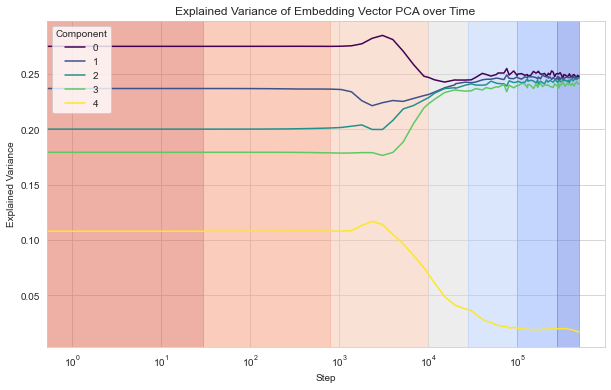

In [91]:
# PCA explained Variance over time
pcas = []

for model in models:
    embed = model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
    pca = PCA(n_components=embed.shape[1])
    proj = pca.fit_transform(embed)[:,:3]
    pcas.append((proj, pca))

explained_variances = [{"value": value, "index": idx, "step": step} for step, (_, pca) in zip(steps, pcas) for idx, value in enumerate(pca.explained_variance_ratio_)]
explained_variances = pd.DataFrame(explained_variances)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')
add_milestones(np.array([ax]))
ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step")

Text(0.5, 0, 'Step')

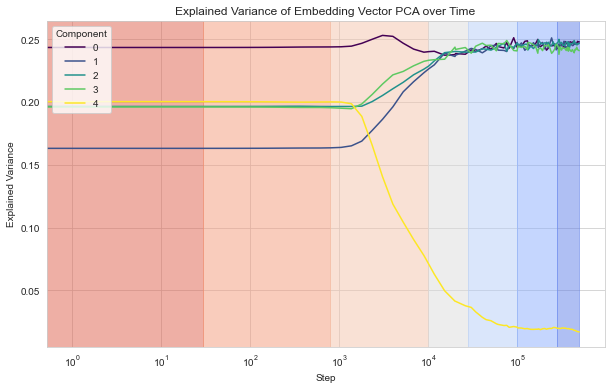

In [94]:
# Using the final PCA

def compute_explained_variance(pca, embed):
    proj = pca.transform(embed)

    # Step 4 and 5: Compute variance of projected data and total variance
    variance_projected = np.var(proj, axis=0)
    total_variance = np.sum(variance_projected)

    # Step 6: Calculate explained variance ratio
    explained_variance_ratio = variance_projected / total_variance

    return explained_variance_ratio

explained_variances_rel_last_pca = [{"value": value, "index": idx, "step": step} for step, embed in zip(steps, embedding_matrices) for idx, value in enumerate(compute_explained_variance(pcas[-1][-1], embed.detach().cpu().numpy()))]
explained_variances_rel_last_pca = pd.DataFrame(explained_variances_rel_last_pca)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances_rel_last_pca, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')
add_milestones(np.array([ax]))
ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step")

## Functional (Loss, Midpoint-Distance, OOD loss)

In [76]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations
from devinfra.utils.iterables import flatten_dict

DEVICE = "mps"

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.pretrain_seed)

# shorthands
B = 1024
K = 8
D = 4

# sample a batch of random tasks
ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D
task_avg = torch.zeros(4).to("mps")
task_avg_repeated = task_avg.unsqueeze(0).repeat(B, 1, 1)

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(B, K, D,),
    device=DEVICE
)

xs100 = 3 * xs
ys = apply_transformations(ws, xs, 0., DEVICE)
ys100 = apply_transformations(ws, xs100, 0., DEVICE)

ys_midpoint = apply_transformations(task_avg_repeated, xs, 0., DEVICE)
ys100_midpoint = apply_transformations(task_avg_repeated, xs100, 0., DEVICE)

def eval_loss(yhats, ys):
    losses = ((yhats - ys) ** 2).mean(dim=0)[:, 0]
    return [loss.item() for loss in losses] + [losses.mean().item()]

losses_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    losses = eval_loss(model(xs, ys), ys)
    loss_midpoints = eval_loss(model(xs, ys), ys_midpoint)
    loss100s = eval_loss(model(xs100, ys100), ys100)
    loss100_midpoints = eval_loss(model(xs100, ys100_midpoint), ys100_midpoint)

    for i in range(9):
        losses_over_time.append({
            "step": step,
            "loss": losses[i],
            "loss100": loss100s[i],
            "loss_midpoint": loss_midpoints[i],
            "loss100_midpoint": loss100_midpoints[i],
            # "token": f"$\hat y_{i+1}$" if i < 8 else "$\overline{\hat y}$"
            "token": i + 1 if i < 8 else "$\overline{\hat y}$"
        })

losses_over_time = pd.DataFrame(losses_over_time)
losses_over_time

,step,loss,loss100,loss_midpoint,loss100_midpoint,token
0,0,4.598032,35.773094,0.645230,0.566119,1
1,0,3.912359,32.107368,0.466606,0.536773,2
2,0,4.903306,38.106960,0.638411,0.586501,3
3,0,4.455447,36.937363,0.422257,0.507210,4
4,0,4.403454,36.047646,0.476724,0.553615,5
...,...,...,...,...,...,...
859,499999,0.880890,15.153487,2.566207,0.406818,5
860,499999,0.484055,12.728300,2.996865,0.338211,6
861,499999,0.437457,12.228322,3.185162,0.383989,7
862,499999,0.282955,12.095072,3.761477,0.396853,8


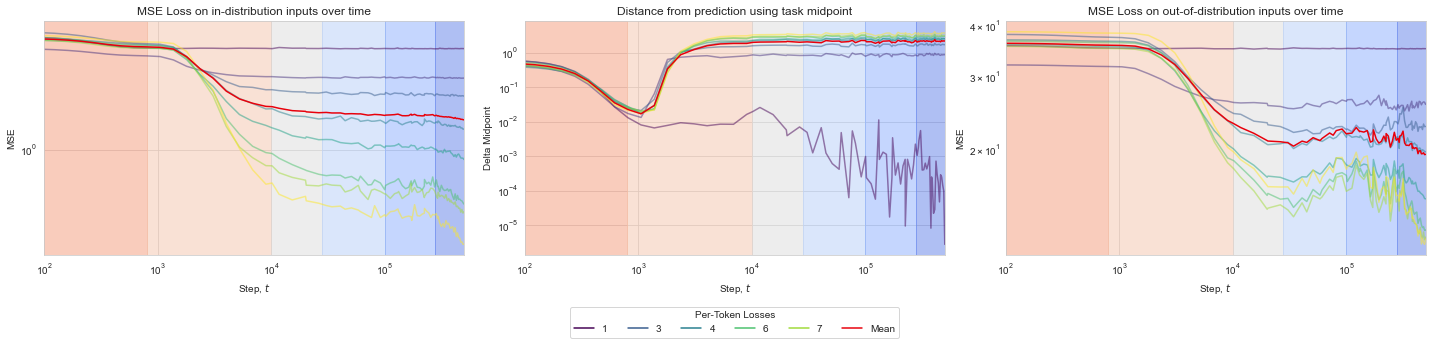

In [77]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

token_losses_over_time = losses_over_time.loc[losses_over_time.token != "$\overline{\hat y}$"]
mean_losses_over_time = losses_over_time.loc[losses_over_time.token == "$\overline{\hat y}$"]

sns.lineplot(data=token_losses_over_time, x="step", y=f"loss", hue="token", palette="viridis", ax=axes[0], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"loss_midpoint", hue="token", palette="viridis", ax=axes[1], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"loss100", hue="token", palette="viridis", ax=axes[2], alpha=0.5)

sns.lineplot(data=mean_losses_over_time, x="step", y="loss", label="Mean", ax=axes[0], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y="loss_midpoint", label="Mean", ax=axes[1], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y="loss100", label="Mean", ax=axes[2], color=BRED)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Step, $t$")
    ax.set_yscale('log')
    legend = ax.legend()
    legend.remove()
    ax.set_xlim(100, 500_000)

legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(MILESTONES))

axes[0].set_title("MSE Loss on in-distribution inputs over time")
axes[0].set_ylabel("MSE")
axes[1].set_title("Distance from prediction using task midpoint")
axes[1].set_ylabel("Delta Midpoint")
axes[2].set_title("MSE Loss on out-of-distribution inputs over time")
axes[2].set_ylabel("MSE")

add_milestones(axes)

for ax in axes:
    ax.set_xscale('log')

plt.tight_layout()
# Add color bar on the far right

fig.set_facecolor('white')

In [5]:
# Confirm that we've loaded in the most recent model
run.evaluator(run.model)

{'pretrain/mse': 1.722325325012207,
 'pretrain/delta_dmmse': tensor(0.1172, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.1165, device='mps:0'),
 'pretrain/token/0': 3.999706268310547,
 'pretrain/token/1': 3.128201961517334,
 'pretrain/token/2': 2.1744866371154785,
 'pretrain/token/3': 1.539637804031372,
 'pretrain/token/4': 1.0379008054733276,
 'pretrain/token/5': 0.8370570540428162,
 'pretrain/token/6': 0.5883678793907166,
 'pretrain/token/7': 0.4732441306114197,
 'true/mse': 1.8321335315704346,
 'true/delta_dmmse': tensor(0.1222, device='mps:0'),
 'true/delta_ridge': tensor(0.1226, device='mps:0'),
 'true/token/0': 4.430878639221191,
 'true/token/1': 3.33992338180542,
 'true/token/2': 2.197641372680664,
 'true/token/3': 1.713287591934204,
 'true/token/4': 1.017869234085083,
 'true/token/5': 0.8117557168006897,
 'true/token/6': 0.6247320175170898,
 'true/token/7': 0.5209808349609375}

In [6]:
list(run.model.state_dict().keys())

['token_sequence_transformer.token_embedding.weight',
 'token_sequence_transformer.postn_embedding.weight',
 'token_sequence_transformer.blocks.0.attention.causal_mask',
 'token_sequence_transformer.blocks.0.attention.attention.weight',
 'token_sequence_transformer.blocks.0.compute.0.weight',
 'token_sequence_transformer.blocks.0.compute.0.bias',
 'token_sequence_transformer.blocks.0.compute.2.weight',
 'token_sequence_transformer.blocks.0.compute.2.bias',
 'token_sequence_transformer.blocks.0.layer_norms.0.weight',
 'token_sequence_transformer.blocks.0.layer_norms.0.bias',
 'token_sequence_transformer.blocks.0.layer_norms.1.weight',
 'token_sequence_transformer.blocks.0.layer_norms.1.bias',
 'token_sequence_transformer.blocks.1.attention.causal_mask',
 'token_sequence_transformer.blocks.1.attention.attention.weight',
 'token_sequence_transformer.blocks.1.compute.0.weight',
 'token_sequence_transformer.blocks.1.compute.0.bias',
 'token_sequence_transformer.blocks.1.compute.2.weight',
 

# PCA

In [183]:
def get_milestone_indices(steps, milestones):
    milestone_indices = []
    for step in steps:
        # Find the index of the milestone that the current step falls into
        index = next((i for i, milestone in enumerate(milestones) if milestone[0] <= step < milestone[1]), None)
        milestone_indices.append(index if index is not None else 'Out of defined milestones')
    return milestone_indices

milestones_of_steps = get_milestone_indices(steps, MILESTONES)

In [109]:
# Do the PCAs again. 
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor
from matplotlib import colors as mcolors


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        hooked_model = hook(model, *paths)
        return {k: convert_tensor(v, return_type) for k, v in hooked_model.run_with_cache(xs, ys)[1].items() if k in paths and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results

from typing import Optional

def plot_sample_evolution(steps, samples, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Main plot
    sc = ax.scatter(samples[:, 0], samples[:, 1], c=steps, cmap='viridis', s=50, alpha=0.6)

    if connect_dots:
        ax.plot(samples[:, 0], samples[:, 1], c='black', alpha=0.2)

    plt.colorbar(sc, ax=ax, label='Steps')
    
    # Label some points
    total_samples = len(samples)
    step = total_samples // num_points_to_label
    for i in range(0, total_samples, step):
        sample_step = steps[i]
        ax.text(samples[i, 0], samples[i, 1], str(sample_step), fontsize=12, ha='right', va='bottom')
        
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)



def plot_sample_evolution_with_inset(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    plot_sample_evolution(steps, samples, title=title, num_points_to_label=num_points_to_label, ax=ax, connect_dots=connect_dots)

    axins = ax.inset_axes([0.7, 0.05, 0.25, 0.25])  # x, y, width, height
    axins.patch.set_alpha(0.5)
    plot_explained_variance(pca, ax=axins)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap
colors = tab10.colors[:len(MILESTONES)]  # Get the first 6 colors

# Create a new colormap from the extracted colors
custom_cmap = mcolors.ListedColormap(colors)


# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)
train_xs_1, train_ys_1 = pretrain_dist_noiseless.get_batch(8, 8196)

pca, logits_reduced = get_pca_activations_trace(
    models,
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    num_components=3
)['token_sequence_transformer']

<ipython-input-109-1275224f3ff2>:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap


In [181]:
# Do the PCAs again. 
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor
from matplotlib import colors as mcolors


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        hooked_model = hook(model, *paths)
        return {k: convert_tensor(v, return_type) for k, v in hooked_model.run_with_cache(xs, ys)[1].items() if k in paths and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_weights_trace(models: Iterable[nn.Module], num_components=3) -> Dict[str, Tuple[PCA, np.ndarray]]:

    def params_to_np_vec(model):
        return np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters()])

    weights = np.array([params_to_np_vec(model) for model in models])

    pca = PCA(n_components=num_components)
    activations_reduced = pca.fit_transform(weights)

    return pca, activations_reduced


# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)
train_xs_1, train_ys_1 = pretrain_dist_noiseless.get_batch(8, 8196)

pca, logits_reduced = get_pca_weights_trace(
    models,
    num_components=3
)

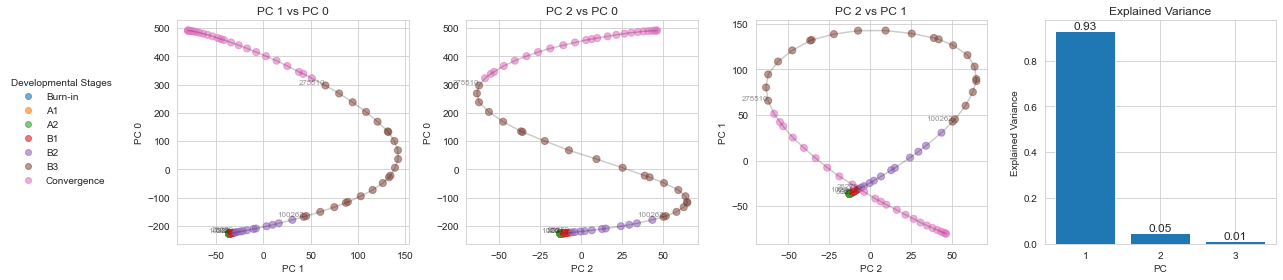

In [185]:
import matplotlib.pyplot as plt
import os
from typing import Optional

def get_milestone_indices(steps, milestones):
    milestone_indices = []
    for step in steps:
        # Find the index of the milestone that the current step falls into
        index = next((i for i, milestone in enumerate(milestones) if milestone[0] <= step < milestone[1]), None)
        milestone_indices.append(index if index is not None else 'Out of defined milestones')
    return milestone_indices

milestones_of_steps = get_milestone_indices(steps, MILESTONES)

highlight_steps = [m1 for m1, m2, _ in MILESTONES][1:]

def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]

highlight_steps = list(map(get_nearest_step, highlight_steps))


def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.set_ylabel('Explained Variance')

    ax.set_xticks(range(len(pca.explained_variance_ratio_)), range(1, len(pca.explained_variance_ratio_) + 1))


def plot_multiple_slices(steps, samples, pca, highlighted_steps, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, connect_dots=False):
    num_pca_components = samples.shape[-1]
    
    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=(20, 4))
    # fig.suptitle(title)

    # Ensure ax is iterable by converting to a list if there's only one subplot
    if num_pca_components == 2:
        axes = [axes]

    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            sc = axes[I].scatter(samples[:, i], samples[:, j], c=milestones_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
            axes[I].set_xlabel(f'PC {i}')
            axes[I].set_ylabel(f'PC {j}')
            axes[I].set_title(f'PC {i} vs PC {j}')

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # Label some points
            total_samples = len(samples)
            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(samples[k, i], samples[k, j], str(step), fontsize=8, ha='right', va='bottom', alpha=0.5)

            I += 1

    plot_explained_variance(pca, ax=axes[-1])
    # for I in range( num_pca_combos):
    #     axes[I].axis('off')
            
    # Colorbar for the last plot
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as necessary
        # plt.colorbar(sc, cax=cbar_ax, label='Milestones')

    # Plot the legend on the first subplot on the left
    legend_ax = axes[0]
    scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=0.6, color=custom_cmap(i)) for i in range(len(milestones_of_steps))]
    legend_labels = [label for _, _, label in MILESTONES]
    legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

# Usage of the function
# Call the function with your data and the list of highlighted steps
# plot_multiple_slices(steps, samples, pca, highlighted_steps=[100, 1000, 10000], title="Your Title", num_points_to_label=10, save="path/to/save.png", connect_dots=True)

plot_multiple_slices(
    steps, 
    logits_reduced, 
    pca, 
    highlight_steps,
    connect_dots=True, 
    title=run.config.to_latex(), 
    save=None
)

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network with PyTorch
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def compute_hessian(loss, parameters):
    # Get the gradient of the loss with respect to all parameters as a single vector
    grads = torch.autograd.grad(loss, parameters, create_graph=True, allow_unused=True)
    parameters_to_ignore = {p: g for p, g in zip(parameters, grads) if g is None}
    parameters_remaining = [p for p in parameters if p not in parameters_to_ignore.keys()]

    grad_vector = torch.cat([g.contiguous().view(-1) for g in grads if g is not None])
    print(grad_vector)

    hessian = []
    for grad in grad_vector:
        # Compute the gradients of each element in the grad_vector w.r.t. all parameters
        grad_grads = torch.autograd.grad(grad, parameters_remaining, retain_graph=True, allow_unused=True)
        # Flatten and concatenate these gradients to form a row of the Hessian
        hessian_row = torch.cat([g.contiguous().view(-1) for g in grad_grads if g is not None])
        hessian.append(hessian_row)
        
    # Stack all rows to form the Hessian matrix
    hessian = torch.stack(hessian)
    return hessian

# # Test the model and the Hessian computation
# model = SimpleNet()
# criterion = nn.MSELoss()

# # Toy data
# x = torch.randn(1, 2)
# y = torch.randn(1, 1)

# # Forward pass
# output = model(x)
# loss = criterion(output, y)

# # Compute Hessian
# parameters = list(model.parameters())
# hessian = compute_hessian(loss, parameters)

# # Print Hessian
# print("Hessian matrix:")
# print(hessian)


In [171]:
import torch
from torch.nn import functional as F


# Assuming `model` is your neural network and `loss_function` is your loss function
# Also assuming `input` is your input tensor and `target` is your target tensor

run.model.to('cpu')

# Forward pass
with torch.enable_grad():
    train_xs_1, train_ys_1 = train_xs_1.to('cpu'), train_ys_1.to('cpu')
    yhats = run.model(train_xs_1, train_ys_1)
    loss = F.mse_loss(train_ys_1, yhats)
    hessian = compute_hessian(loss, list(run.model.parameters()))

# Now `hessian` is a matrix containing the second-order partial derivatives

tensor([-0.0004,  0.0005,  0.0005,  ...,  0.0000,  0.0000,  0.0000],
       grad_fn=<CatBackward0>)


KeyboardInterrupt: 

In [169]:
run.model.named_parameters

<bound method Module.named_parameters of InContextRegressionTransformer(
  (token_sequence_transformer): DTransformer(
    (token_embedding): Linear(in_features=5, out_features=64, bias=False)
    (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
    (blocks): ModuleList(
      (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
        (attention): MultiHeadedCausalSelfAttention(
          (attention): Linear(in_features=64, out_features=192, bias=False)
          (attention_softmax): Softmax(dim=-1)
        )
        (compute): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (resid_after_attn): Identity()
      )
    )
    (unembedding): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine

In [ ]:
import torch as t
from torch.autograd import grad
from scipy.sparse.linalg import LinearOperator, eigsh
import numpy as np


def get_hessian_eigenvectors(model, loss_fn, train_data_loader, num_batches, device, n_top_vectors, param_extract_fn):
   """
   model: a pytorch model
   loss_fn: a pytorch loss function
   train_data_loader: a pytorch data loader
   num_batches: number of batches to use for the hessian calculation
   device: the device to use for the hessian calculation
   n_top_vectors: number of top eigenvalues / eigenvectors to return
   param_extract_fn: a function that takes a model and returns a list of parameters to compute the hessian with respect to (pass None to use all parameters)
   returns: a tuple of (eigenvalues, eigenvectors)
   eigenvalues: a numpy array of the top eigenvalues, arranged in increasing order
   eigenvectors: a numpy array of the top eigenvectors, arranged in increasing order, shape (n_top_vectors, num_params)
   """
   param_extract_fn = param_extract_fn or (lambda x: x.parameters())
   num_params = sum(p.numel() for p in param_extract_fn(model))
   subset_images, subset_labels = [], []
   for batch_idx, (images, labels) in enumerate(train_data_loader):
       if batch_idx >= num_batches:
           break
       subset_images.append(images.to(device))
       subset_labels.append(labels.to(device))
   subset_images = t.cat(subset_images)
   subset_labels = t.cat(subset_labels)
   def compute_loss():
       output = model(subset_images)
       return loss_fn(output, subset_labels)
   
   def hessian_vector_product(vector):
       model.zero_grad()
       grad_params = grad(compute_loss(), param_extract_fn(model), create_graph=True)
       flat_grad = t.cat([g.view(-1) for g in grad_params])
       grad_vector_product = t.sum(flat_grad * vector)
       hvp = grad(grad_vector_product, param_extract_fn(model), retain_graph=True)
       return t.cat([g.contiguous().view(-1) for g in hvp])
   
   def matvec(v):
       v_tensor = t.tensor(v, dtype=t.float32, device=device)
       return hessian_vector_product(v_tensor).cpu().detach().numpy()
   
   linear_operator = LinearOperator((num_params, num_params), matvec=matvec)
   eigenvalues, eigenvectors = eigsh(linear_operator, k=n_top_vectors, tol=0.001, which='LM', return_eigenvectors=True)
   eigenvectors = np.transpose(eigenvectors)
   return eigenvalues, eigenvectors